In [10]:
def download_file(output_file):
    url = 'https://datasets.imdbws.com/'+output_file+'.tsv.gz'
    response = requests.get(url)

    if response.status_code == 200:
        with open(output_file+'.tsv.gz', 'wb') as f:
            f.write(response.content)
    else:
        print('Request failed with status code:', response.status_code)

def open_file(output_file,cols_to_read = None):
    file = output_file+'.tsv.gz'
    with gzip.open(file, 'rt', encoding='utf-8') as gz_file:
        df = pd.read_csv(gz_file, delimiter='\t', na_values='\\N', usecols = cols_to_read)    

    return df

def preprcosData(titles, ratings, crew):
    titles = titles[titles['titleType'] == 'movie'] #remove all non-movie titles
    titles = titles.merge(ratings, on='tconst', how='inner')
    titles = titles.merge(crew, on='tconst', how='inner')
    titles['runtimeMinutes'] = pd.to_numeric(titles['runtimeMinutes'], errors='coerce')
    titles = titles.dropna()

    # Convert data types
    titles['startYear'] = titles['startYear'].astype(int)
    titles['averageRating'] = titles['averageRating'].astype(float)
    titles['numVotes'] = titles['numVotes'].astype(int)


    del ratings
    del crew
    
    # Filter the data by removing NAs and unwanted values
    titles = titles.dropna(subset=['startYear', 'runtimeMinutes', 'averageRating', 'numVotes', 'directors'])

    return titles

def filtertitles(titles,
                    maxyear= None,
                    minyear= float(1900),
                    maxRuntime= float(300),
                    genre = None,
                    minVotes = float(0),
                    minRating= float(0),
                    English = True,
                    verbose = False):

    #Filter max year
    if maxyear == None:
        titles = titles[titles['startYear'] <= datetime.now().year]
        if verbose:
            print('max year: this year')
    else:
        titles = titles[titles['startYear'] <= maxyear]
        if verbose:
            print('max year:', maxyear)
    if verbose:
        print('# titles:', len(titles))

    #Filter min year
    titles = titles[titles['startYear'] >= minyear]
    if verbose:
        print('min year:', minyear)
        print('# titles:', len(titles))

    #Filter max runtime    
    titles = titles[titles['runtimeMinutes'] <= maxRuntime]
    if verbose:
        print('max runtime:', maxRuntime)
        print('# titles:', len(titles))

    #Filter number of votes
    titles = titles[titles['numVotes'] >= minVotes]
    if verbose:
        print('min votes:', minVotes)
        print('# titles:', len(titles))

    #filter rating
    titles = titles[titles['averageRating'] >= minRating]
    if verbose:
        print('minimum rating:', minRating)
        print('# titles:', len(titles))

    #filter language
    if English:
        titles = titles[titles['primaryTitle'] == titles['originalTitle']]
        if verbose:
            print('only English movies')
            print('# titles:', len(titles))


    #filter by genre
    if genre is not None:
        titles = titles[titles['genres'].str.contains(genre)]
        if verbose:
            print('genre:', genre)
            print('# titles:', len(titles))


    return titles

def get_director_ID(csv_file, director):
    # Read the file in chunks
    chunk_size = 10000
    for chunk in pd.read_csv(csv_file, chunksize=chunk_size, delimiter='\t', usecols=['nconst', 'primaryName'], na_values='\\N'):
        # Search within the chunk
        subset = chunk[chunk['primaryName'] == director]
        if not subset.empty:
            # Return the 'nconst' value from the first matching row found
            return subset['nconst'].iloc[0]

    # Return None if no match is found
    print('ERROR: director'+director+' not found')
    return None

def filterDirector(titles, directorID):
    
    if directorID is not None:
        titles = titles[titles['directors'].str.contains(directorID)]
        print('director:', directorID)
    else:
        print('ERROR: director not found')
        titles = None

    return titles

def printMovies(titles, TopX = 10):
    results = titles.head(TopX)
    print('Best movies:')
    num = 1
    for row in results.iterrows():
        print('======================'+str(num)+'=======================')
        print(row[1]['primaryTitle'],
              '\nYear', row[1]['startYear'],
              '\nRating',row[1]['averageRating'],
             '\nVotes',row[1]['numVotes'],
             '\ngenres', row[1]['genres'])
        num += 1
    return results

def FindMovies(
               director = None,
               maxyear= None,
                minyear= float(1900),
                maxRuntime= float(500),
                genres = None,
                minVotes = float(0),
                minRating= float(0),
                English = True,
                sortBy = ['startYear', 'numVotes', 'averageRating'],
                TopX = 10,
                downloadIMDB = True,
                verbose = False,
                blockbuster = False):
    

    #Download the data from IMDB
    if downloadIMDB:
        for file in ['title.basics', 'title.ratings', 'name.basics', 'title.crew']:
            print('Downloading', file, 'from IMDB...')
            download_file(file)
    else:
        print('Using locally available data')
        if not os.path.exists('title.basics.tsv.gz') or not os.path.exists('title.ratings.tsv.gz') or not os.path.exists('name.basics.tsv.gz'):
            print('ERROR: Locally available data not found. Please set downloadIMDB to True or download the data manually from https://www.imdb.com/interfaces/ and place the files in the current directory.')
            return

    # Loading the data
    print('Loading titles...')
    titles = open_file('title.basics',cols_to_read = ['tconst','titleType','primaryTitle','originalTitle','startYear','runtimeMinutes','genres'])
    print('Loading ratings...')
    ratings = open_file('title.ratings',cols_to_read = ['tconst','averageRating','numVotes'])
    print('Loading crew...')
    crew = open_file('title.crew',cols_to_read = ['tconst','directors'])

    # Preprocessing the data
    titles = preprcosData(titles, ratings, crew)

    #Filter the data
    if blockbuster:
        minVotes = 1000000
        English = True
    titles = filtertitles(titles, maxyear, minyear, maxRuntime, genres, minVotes, minRating, English,verbose = verbose)

    #Filter the director
    if director is not None:
        directorID = get_director_ID('name.basics.tsv.gz', director)
        titles = filterDirector(titles, directorID)

    #Sort the data
    titles = titles.sort_values(by=sortBy)

    #return the top X movies
    results = titles.head(TopX)

    #print results
    print('Best movies:')
    for row in results.iterrows():
        print(row[1]['primaryTitle'], row[1]['startYear'], row[1]['averageRating'], row[1]['numVotes'])

    #save resuls as csv
    results.to_csv('Movies.csv', index=False)
    return
         


## Anlysis for the IMDB database
Here I present some basic analysis of the movies available in the IMDB dataset. The analysis uses the function MovieFinder which is included in folder. 
# Steps in the analysis:
1. Loading all the data.
2. Using pre-selected filters to focus on blockbuster movies. 
3. graphs for the following data:
    1. 
    2. 
    3.
    4.
    
Loading the MovieFinder package (c).
If the data was not downloaded from IMDB before, downloadIMDB must be set to true.

If the data already exists in the folder, downloadIMDB should be set to False in order to save time. 

In [62]:
import gzip
import shutil
import requests
import pandas as pd
import csv
from io import StringIO
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

import MovieFinder as mf
downloadIMDB = True


In [ ]:
test = FindMovies(downloadIMDB=False,verbose=False,director='Christopher Nolan',maxyear=2020,TopX=10)

# Download the data if needed (~0.5 min):

In [14]:
if downloadIMDB == True:
    for file in ['title.basics', 'title.ratings', 'name.basics', 'title.crew']:
        mf.download_file(file)

# Loading the data (~1 min)

In [77]:
print('Loading titles...')
titles = open_file('title.basics',cols_to_read = ['tconst','titleType','primaryTitle','originalTitle','startYear','runtimeMinutes','genres'])
print('Loading ratings...')
ratings = open_file('title.ratings',cols_to_read = ['tconst','averageRating','numVotes'])
print('Loading crew...')
crew = open_file('title.crew',cols_to_read = ['tconst','directors'])
print('Loading names...')
print('Done!')

Loading titles...


C:\Users\nadav\AppData\Local\Temp\ipykernel_8612\250932813.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(gz_file, delimiter='\t', na_values='\\N', usecols = cols_to_read)


Loading ratings...
Loading crew...
Loading names...
Done!


# Preprocessing (~0.5 min)

In [78]:
titles = preprcosData(titles, ratings, crew)
titles.head(10)

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894,45.0,Romance,5.3,208,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,100.0,"Documentary,News,Sport",5.2,502,nm0714557
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70.0,"Action,Adventure,Biography",6.0,871,nm0846879
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,1907,90.0,Drama,5.5,23,nm0141150
8,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120.0,"Adventure,Fantasy",5.0,70,"nm0091767,nm0877783"
11,tt0000941,movie,Locura de amor,Locura de amor,1909,45.0,Drama,4.5,27,"nm0063413,nm0550220"
25,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,1910,58.0,"Adventure,Drama",3.8,22,"nm0063413,nm0550220"
29,tt0001285,movie,The Life of Moses,The Life of Moses,1909,50.0,"Biography,Drama,Family",5.4,60,nm0085865
39,tt0001498,movie,The Battle of Trafalgar,The Battle of Trafalgar,1911,51.0,War,7.8,14,nm0205986
43,tt0001592,movie,In the Prime of Life,Ekspeditricen,1911,52.0,Drama,6.0,27,nm0088881


# Filter for Hollywood blockbusters

In [87]:
director = None                                         #Name of director (str)
maxyear= None                                           #Maximum year of release (int)
minyear= float(1900)                                    #Minimum year of release(int)
maxRuntime= float(500)                                  #Maximum runtime in minutes (float)
genres = None                                           #Genre (str)
minVotes = 100000                                       #Minimum number of votes (int)
minRating= float(0)                                     #Minimum rating (float)
English = True                                          #Only English movies (bool)
sortBy = ['startYear', 'numVotes', 'averageRating']     #Sort by (list of str)
TopX = 10                                               #Number of movies to return (int)
downloadIMDB = True                                     #Download the IMDB data (bool)

results = filtertitles(titles = titles,
                     maxyear = maxyear,
                    minyear = minyear,
                    maxRuntime = maxRuntime,
                    minVotes = minVotes,
                    minRating = minRating,
                    English = English,
                    genre = genres,
                    verbose = True)

#All available genres
#['Drama', 'Crime', 'Action', 'Adventure', 'Biography', 'History', 'Sci-Fi', 'Romance', 
# 'Fantasy', 'Mystery', 'Thriller', 'War', 'Family', 'Animation', 'Western', 'Comedy', 
# 'Music', 'Horror', 'Film-Noir', 'Musical', 'Sport', 'Documentary']


max year: this year
# titles: 268007
min year: 1900.0
# titles: 268005
max runtime: 500.0
# titles: 267964
min votes: 100000
# titles: 2394
minimum rating: 0.0
# titles: 2394
only English movies
# titles: 2253


# Sort the titles

In [88]:
sortBy = [ 'averageRating','numVotes','startYear']     #Sort by (list of str)
results = results.sort_values(by=sortBy, ascending = [False, False, False])


In [89]:
results.head(10)

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
61482,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,1994,142.0,Drama,9.3,2866302,nm0001104
36659,tt0068646,movie,The Godfather,The Godfather,1972,175.0,"Crime,Drama",9.2,1996593,nm0000338
226610,tt23849204,movie,12th Fail,12th Fail,2023,147.0,"Biography,Drama",9.1,101826,nm0006765
136805,tt0468569,movie,The Dark Knight,The Dark Knight,2008,152.0,"Action,Crime,Drama",9.0,2847831,nm0634240
78769,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,2003,201.0,"Action,Adventure,Drama",9.0,1963343,nm0001392
59906,tt0108052,movie,Schindler's List,Schindler's List,1993,195.0,"Biography,Drama,History",9.0,1439792,nm0000229
38572,tt0071562,movie,The Godfather Part II,The Godfather Part II,1974,202.0,"Crime,Drama",9.0,1354649,nm0000338
23622,tt0050083,movie,12 Angry Men,12 Angry Men,1957,96.0,"Crime,Drama",9.0,856821,nm0001486
188989,tt15239678,movie,Dune: Part Two,Dune: Part Two,2024,166.0,"Action,Adventure,Drama",9.0,123387,nm0898288
61335,tt0110912,movie,Pulp Fiction,Pulp Fiction,1994,154.0,"Crime,Drama",8.9,2201269,nm0000233


# Print top 10 results

In [90]:
printMovies(results)

Best movies:
======================1=======================
The Shawshank Redemption 
Year 1994 
Rating 9.3 
Votes 2866302 
genres Drama
======================2=======================
The Godfather 
Year 1972 
Rating 9.2 
Votes 1996593 
genres Crime,Drama
======================3=======================
12th Fail 
Year 2023 
Rating 9.1 
Votes 101826 
genres Biography,Drama
======================4=======================
The Dark Knight 
Year 2008 
Rating 9.0 
Votes 2847831 
genres Action,Crime,Drama
======================5=======================
The Lord of the Rings: The Return of the King 
Year 2003 
Rating 9.0 
Votes 1963343 
genres Action,Adventure,Drama
======================6=======================
Schindler's List 
Year 1993 
Rating 9.0 
Votes 1439792 
genres Biography,Drama,History
======================7=======================
The Godfather Part II 
Year 1974 
Rating 9.0 
Votes 1354649 
genres Crime,Drama
======================8=======================
12 Angry Men 
Year 1957 
Rat

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors
61482,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,1994,142.0,Drama,9.3,2866302,nm0001104
36659,tt0068646,movie,The Godfather,The Godfather,1972,175.0,"Crime,Drama",9.2,1996593,nm0000338
226610,tt23849204,movie,12th Fail,12th Fail,2023,147.0,"Biography,Drama",9.1,101826,nm0006765
136805,tt0468569,movie,The Dark Knight,The Dark Knight,2008,152.0,"Action,Crime,Drama",9.0,2847831,nm0634240
78769,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,2003,201.0,"Action,Adventure,Drama",9.0,1963343,nm0001392
59906,tt0108052,movie,Schindler's List,Schindler's List,1993,195.0,"Biography,Drama,History",9.0,1439792,nm0000229
38572,tt0071562,movie,The Godfather Part II,The Godfather Part II,1974,202.0,"Crime,Drama",9.0,1354649,nm0000338
23622,tt0050083,movie,12 Angry Men,12 Angry Men,1957,96.0,"Crime,Drama",9.0,856821,nm0001486
188989,tt15239678,movie,Dune: Part Two,Dune: Part Two,2024,166.0,"Action,Adventure,Drama",9.0,123387,nm0898288
61335,tt0110912,movie,Pulp Fiction,Pulp Fiction,1994,154.0,"Crime,Drama",8.9,2201269,nm0000233


# Looking at movies of specific directors (example: Peter Jackson)

In [91]:
director_name = 'Peter Jackson'
director_ID = get_director_ID('name.basics.tsv.gz', director_name)

director_Movies = filterDirector(results, director_ID).sort_values('averageRating', ascending=True)

director: nm0001392


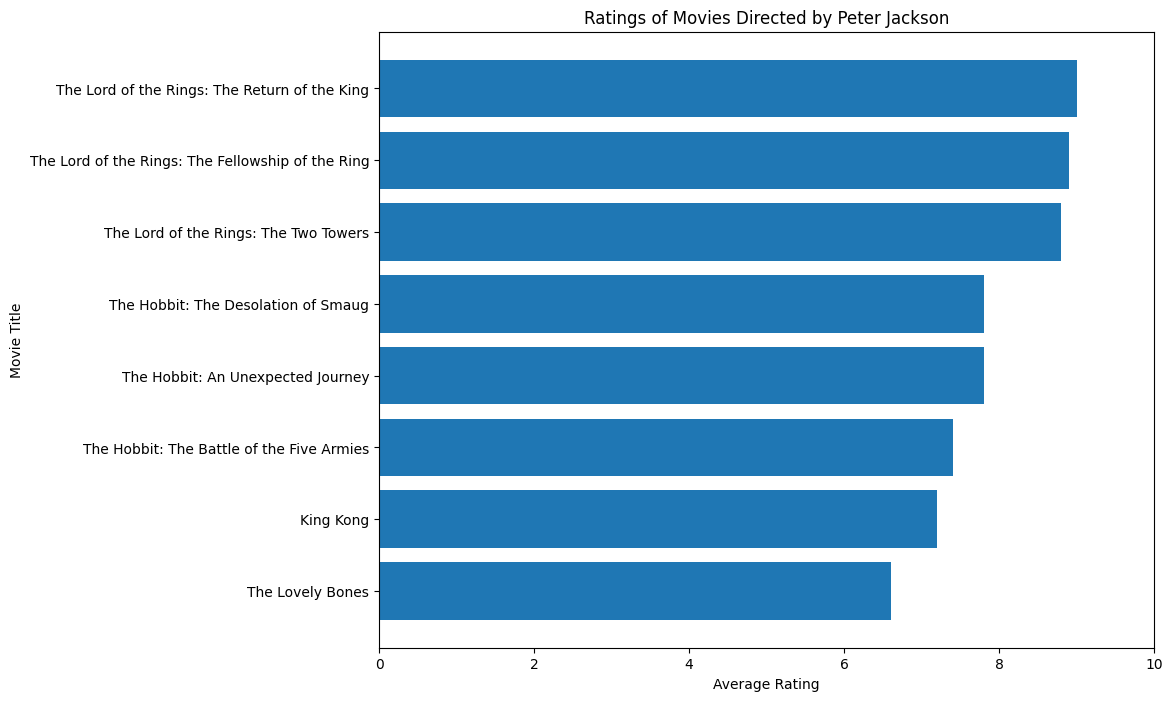

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figsize as per your preference
ax.barh(director_Movies['primaryTitle'], director_Movies['averageRating'])
ax.set_title(f'Ratings of Movies Directed by {director_name}')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Movie Title')
ax.set_xlim(0, 10)
plt.show()

# Rating trends in IMDB blockbusters

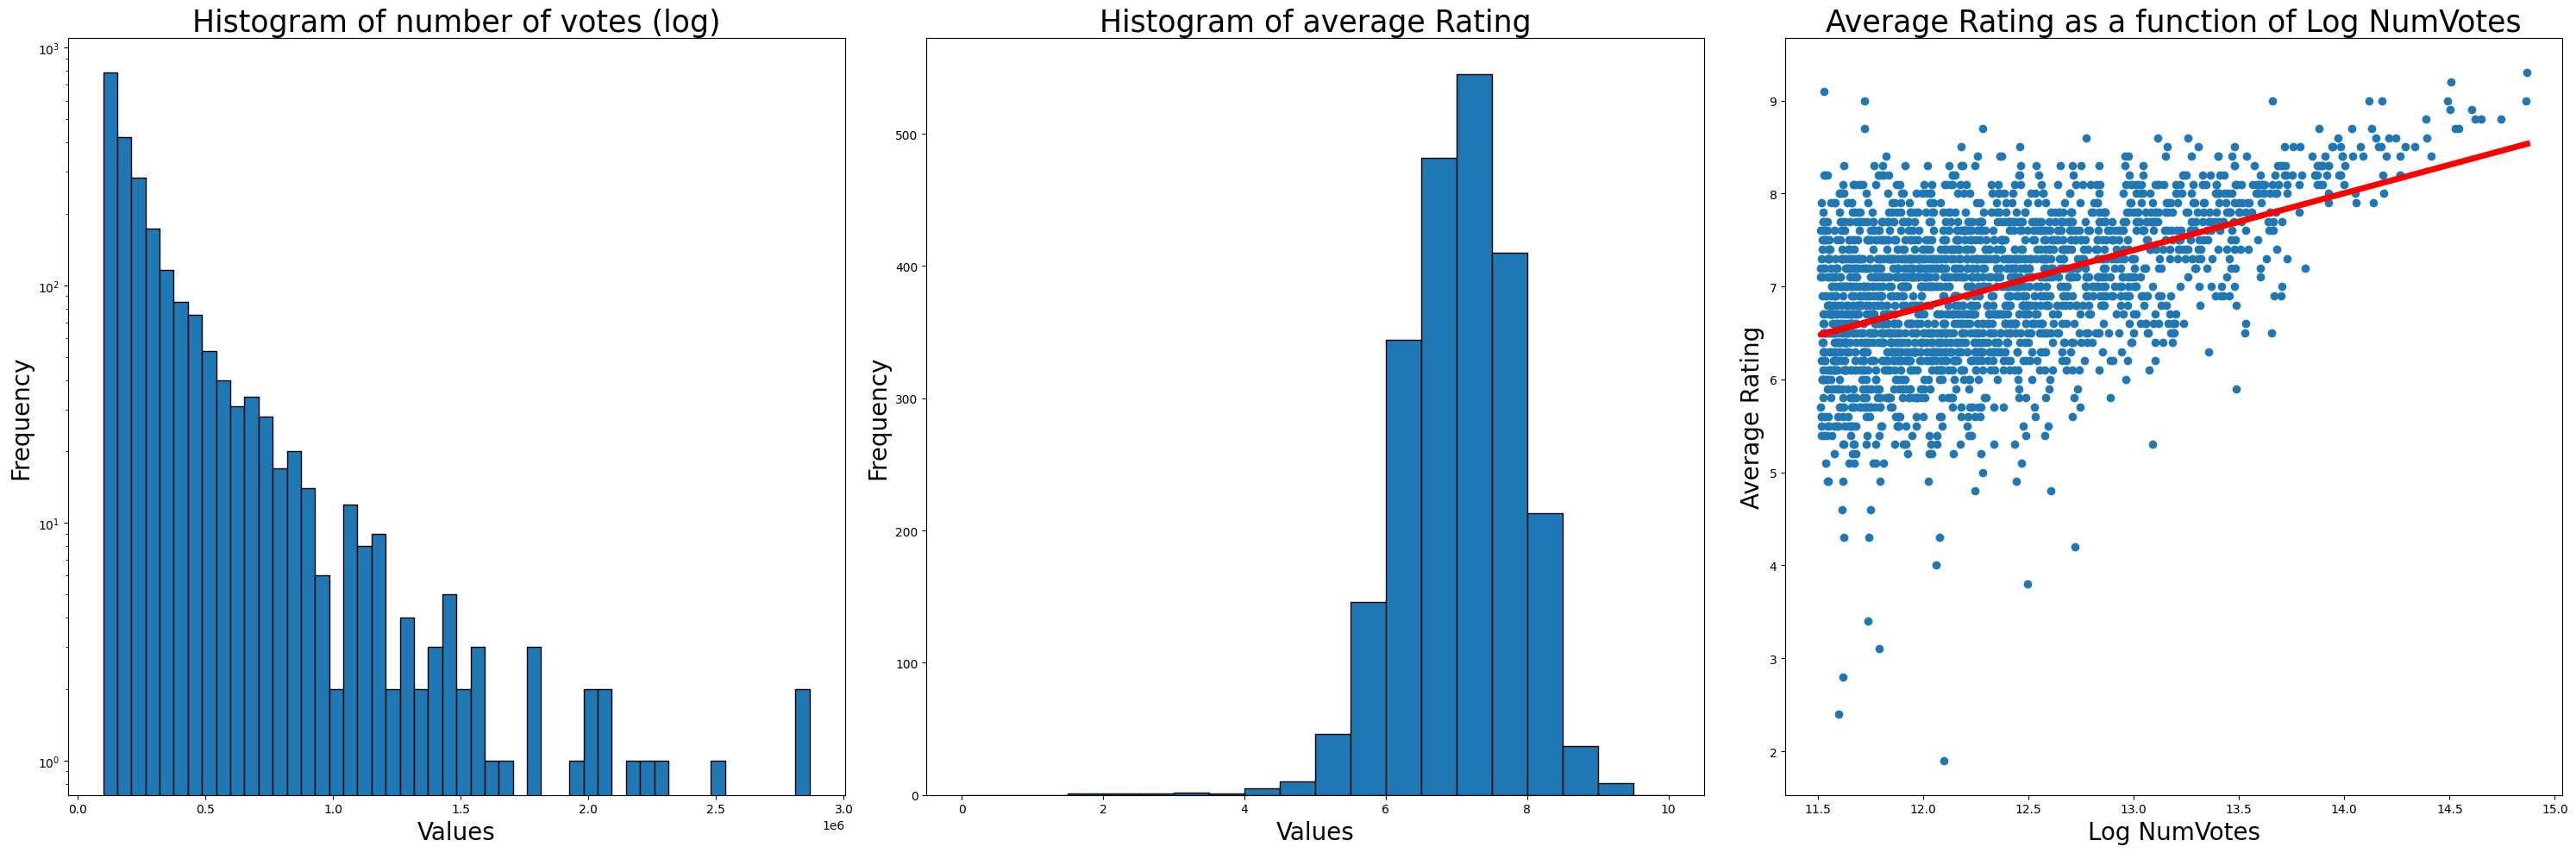

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 2 columns

num_bins = 10
# Plotting the first histogram
axs[0].hist(results['numVotes'], bins=50, edgecolor='black', log=True)
axs[0].set_title('Histogram of number of votes (log)', fontsize=25)
axs[0].set_xlabel('Values', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

# Plotting the second histogram
axs[1].hist(results['averageRating'], bins=20, edgecolor='black', log=False, range = (0,10))
axs[1].set_title('Histogram of average Rating', fontsize=25)
axs[1].set_xlabel('Values', fontsize=20)
axs[1].set_ylabel('Frequency', fontsize=20)

# Plotting the average rating as a function of vots
from sklearn.linear_model import LinearRegression
axs[2].scatter(np.log(results['numVotes']), results['averageRating'])
axs[2].set_title('Average Rating as a function of Log NumVotes', fontsize=25)
axs[2].set_xlabel('Log NumVotes', fontsize=20)
axs[2].set_ylabel('Average Rating', fontsize=20)

X = np.log(results['numVotes']).values.reshape(-1, 1)
y = results['averageRating'].values

model = LinearRegression()
model.fit(X, y)
axs[2].plot(X, model.predict(X), color='red', label='Linear Regression', linewidth=5)


# Adjust layout to prevent clipping of results
plt.tight_layout()

# Show the plot
plt.show()

# Trends over time

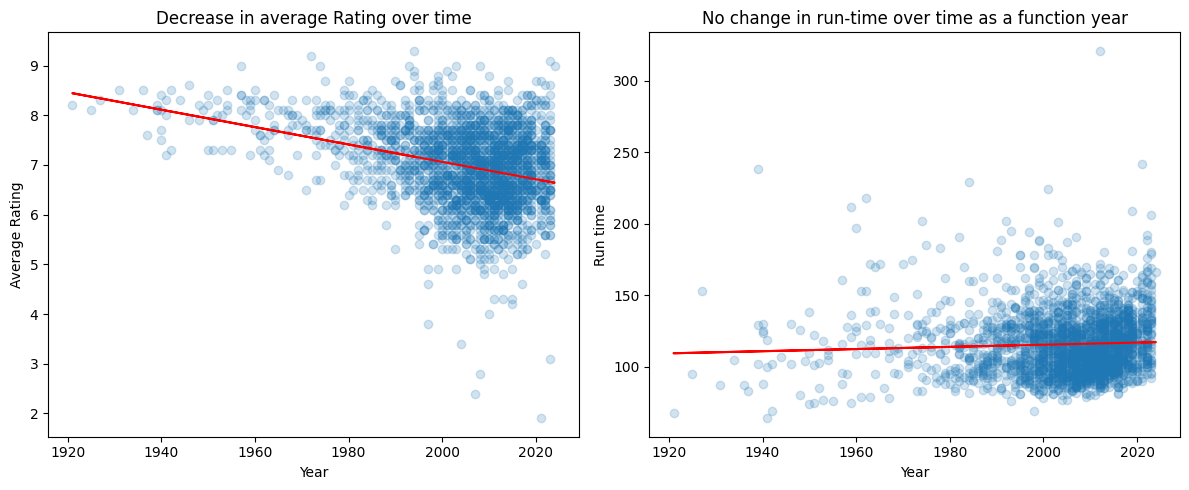

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(results['startYear'], results['averageRating'],alpha=0.2)
axs[0].set_title('Decrease in average Rating over time')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Average Rating')
X = results['startYear'].values.reshape(-1, 1)
y = results['averageRating'].values
model = LinearRegression()
model.fit(X, y)
axs[0].plot(X, model.predict(X), color='red', label='Linear Regression')


axs[1].scatter(results['startYear'], results['runtimeMinutes'],alpha=0.2)
axs[1].set_title('No change in run-time over time as a function year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Run time')
X = results['startYear'].values.reshape(-1, 1)
y = results['runtimeMinutes'].values
model = LinearRegression()
model.fit(X, y)
axs[1].plot(X, model.predict(X), color='red', label='Linear Regression')

plt.tight_layout()

# Show the plots
plt.show()


# Comparison of Genres

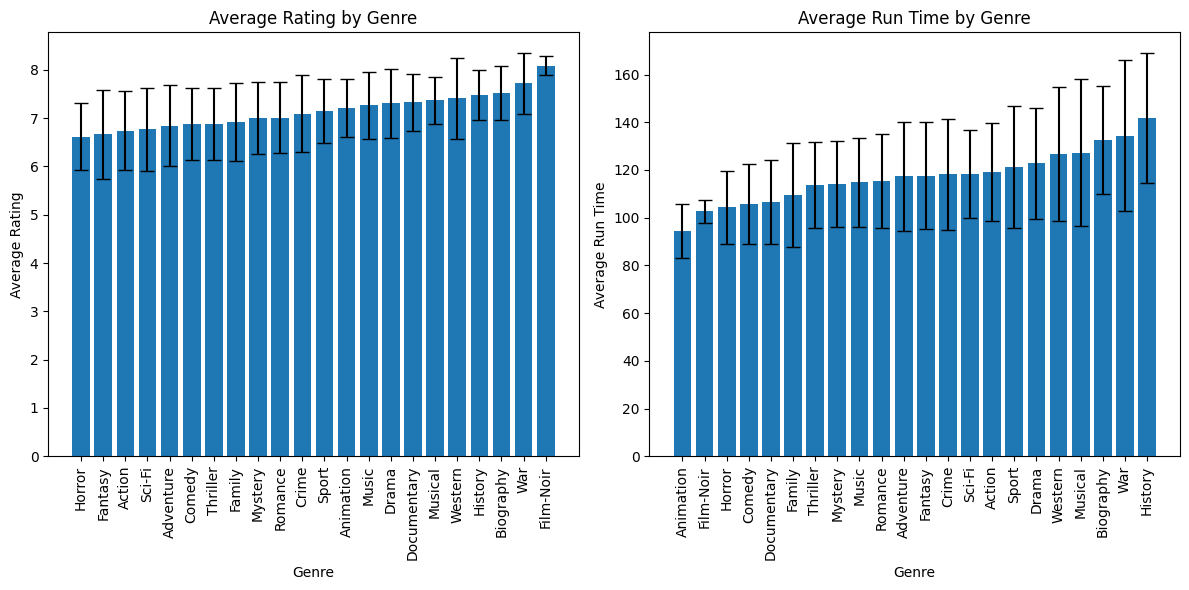

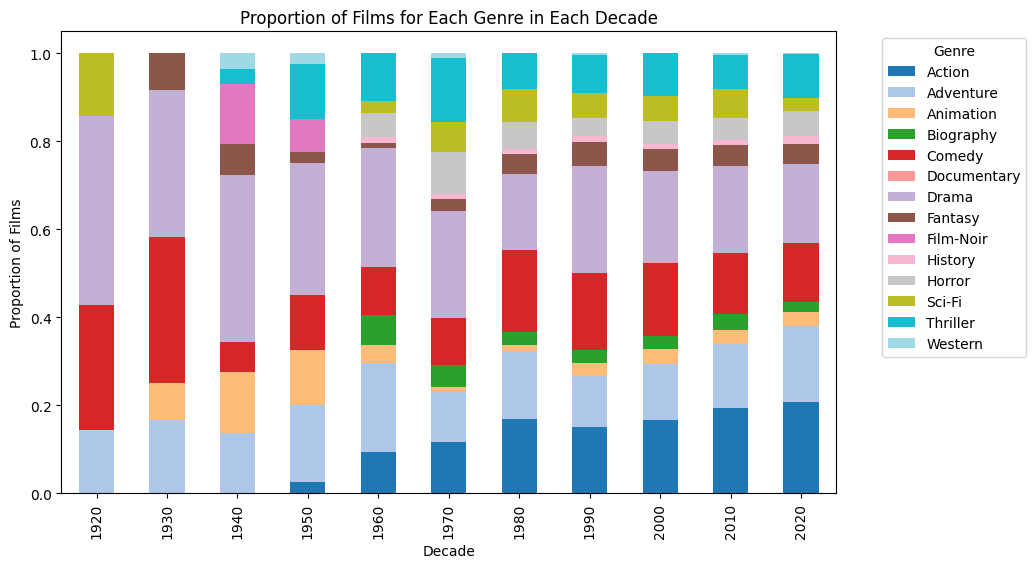

In [115]:
import copy

resultsG = copy.deepcopy(results)
resultsG['genres'] = resultsG['genres'].str.split(',')
resultsG = resultsG.explode('genres')

unique_values_list = resultsG['genres'].unique().tolist()

grouped_data = resultsG.groupby('genres')['averageRating'].agg(['mean', 'std'])

# Sorting in ascending order
grouped_data = grouped_data.sort_values(by='mean')

# Plotting average rating by genre

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation='vertical')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
grouped_data = resultsG.groupby('genres')['runtimeMinutes'].agg(['mean', 'std'])
grouped_data = grouped_data.sort_values(by='mean')
plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
plt.title('Average Run Time by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Run Time')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()



genres_to_filter = ['Drama', 'Action', 'Adventure', 'Biography', 
                    'History', 'Sci-Fi', 'Fantasy',
                      'Thriller', 'Animation', 'Western',
                        'Comedy', 'Horror', 'Film-Noir',
                          'Documentary']


resultsG = resultsG[resultsG['genres'].isin(genres_to_filter)]


resultsG['decade'] = (resultsG['startYear'] // 10) * 10
# Step 2: Count the number of films for each combination of decade and genre
decade_genre_counts = resultsG.groupby(['decade', 'genres']).size().unstack(fill_value=0)

# Step 3: Normalize the data
normalized_counts = decade_genre_counts.div(decade_genre_counts.sum(axis=1), axis=0)

# Step 4: Plot the stacked histogram
normalized_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Proportion of Films for Each Genre in Each Decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of Films')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Save results to CSV format

In [226]:
#save list to csv
titles.to_csv('titles.csv', index=False)